<a href="https://colab.research.google.com/github/Dhaneshkp/DesktopAssistant/blob/main/Premium_GAN_wRealdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

Everst_data=pd.read_csv(r'Everest_data.csv')
data=Everst_data
data['Attained_age']=data['Age']+data['Duration']
data['Premium_rate']=data['BasePremiumAmount']/data['BaseNARAmount']*10000
exclude_cols = ['Gender','RiskClass']
Coulmns_to_keep=['Attained_age','Premium_rate']
data=data[data['SingleOrJointType']=="Single"]
data=data[data['Gender']=="Male"]
data=data[data['RiskClass']=="NS1"]
data=data[Coulmns_to_keep]
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns
#data.iloc[4::5, 1] = np.nan
test_data=data.head(1000)
test_data


<ipython-input-6-dc912475ed2b>:6: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  Everst_data=pd.read_csv(r'Everest_data.csv')


,Attained_age,Premium_rate
0,41,3.795200
2,53,9.488000
4,59,22.345600
8,49,12.331262
9,60,24.558570
...,...,...
1424,67,53.121600
1425,46,6.851740
1427,30,3.580196
1428,48,7.422906


In [12]:
# prompt: Using dataframe test_data: find the regression for  test_dat to predict premium

import statsmodels.formula.api as sm

# Fit a linear regression model
result = sm.ols('Premium_rate ~ Attained_age', data=test_data).fit()

# Print the regression summary
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:           Premium_rate   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     1414.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          2.09e-193
Time:                        03:08:16   Log-Likelihood:                -3800.8
No. Observations:                1000   AIC:                             7606.
Df Residuals:                     998   BIC:                             7615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -37.1802      1.365    -27.232   

Epoch 0/10000, Loss D: 0.39564454555511475, Loss G: 1375.13818359375
Epoch 1000/10000, Loss D: 0.0002532313228584826, Loss G: 15.903070449829102
Epoch 2000/10000, Loss D: 0.43823954463005066, Loss G: 4.460354804992676
Epoch 3000/10000, Loss D: 0.49177441000938416, Loss G: 6.72865104675293
Epoch 4000/10000, Loss D: 0.5646286010742188, Loss G: 5.369232654571533
Epoch 5000/10000, Loss D: 0.5329936146736145, Loss G: 4.378474235534668
Epoch 6000/10000, Loss D: 0.5998818278312683, Loss G: 5.746187686920166
Epoch 7000/10000, Loss D: 0.5328346490859985, Loss G: 3.678305149078369
Epoch 8000/10000, Loss D: 0.5663578510284424, Loss G: 3.7859842777252197
Epoch 9000/10000, Loss D: 0.5509379506111145, Loss G: 3.270618438720703


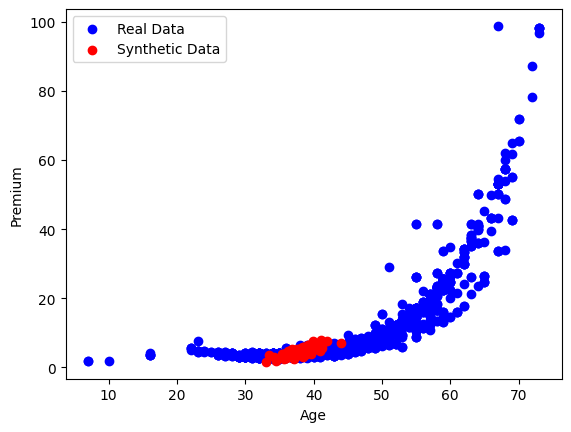

In [17]:
import torch

import torch.nn as nn

import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

# Define the Generator

class Generator(nn.Module):

    def __init__(self, noise_dim, output_dim):

        super(Generator, self).__init__()

        self.model = nn.Sequential(

            nn.Linear(noise_dim, 128),

            nn.ReLU(),

            nn.Linear(128, 128),

            nn.ReLU(),

            nn.Linear(128, output_dim)

        )



    def forward(self, x):

        return self.model(x)

# Define the Discriminator

class Discriminator(nn.Module):

    def __init__(self, input_dim):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(

            nn.Linear(input_dim, 128),

            nn.ReLU(),

            nn.Linear(128, 128),

            nn.ReLU(),

            nn.Linear(128, 1),

            nn.Sigmoid()

        )



    def forward(self, x):

        return self.model(x)

# Generate real data

def get_real_data(num_samples):

    # Simulating some real data for demonstration

    ages = np.random.uniform(18, 70, size=num_samples)

    premiums = -37.1802       + ages * 1.0962   + np.random.normal(0, 10, size=num_samples)  # Example regression line

    data = test_data.sample(n=num_samples, replace=True).values #np.column_stack((ages, premiums))

    return torch.tensor(data, dtype=torch.float32)

# Hyperparameters

noise_dim = 1000

feature_dim = 1  # 'age' as feature

predictor_dim = 1  # 'premium' as predictor

num_epochs = 10000

batch_size = 64

# Models

generator = Generator(noise_dim, feature_dim + predictor_dim)

discriminator = Discriminator(feature_dim + predictor_dim)

# Optimizers

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss functions

adversarial_loss = nn.BCELoss()

regression_loss = nn.MSELoss()

# Training

for epoch in range(num_epochs):

    # Train Discriminator

    real_data = get_real_data(batch_size)



    # Real data

    real_labels = torch.ones(batch_size, 1)

    output_real = discriminator(real_data)

    loss_real = adversarial_loss(output_real, real_labels)



    # Fake data

    noise = torch.randn(batch_size, noise_dim)

    fake_data = generator(noise)

    fake_labels = torch.zeros(batch_size, 1)

    output_fake = discriminator(fake_data.detach())

    loss_fake = adversarial_loss(output_fake, fake_labels)



    # Total discriminator loss

    loss_D = (loss_real + loss_fake) / 2



    optimizer_D.zero_grad()

    loss_D.backward()

    optimizer_D.step()



    # Train Generator

    output_fake = discriminator(fake_data)

    loss_G_adv = adversarial_loss(output_fake, real_labels)



    # Regression constraint

    real_features = real_data[:, 0]  # 'age'

    real_predictor = real_data[:, 1]  # 'premium'

    fake_features = fake_data[:, 0]

    fake_predictor = fake_data[:, 1]



    # For simplicity, assume a linear regression model with known coefficients

    regression_model = lambda x: -37.1802       + x * 1.0962

    predicted_predictor = regression_model(fake_features)

    loss_G_reg = regression_loss(predicted_predictor, fake_predictor)



    # Total generator loss

    loss_G = loss_G_adv + loss_G_reg



    optimizer_G.zero_grad()

    loss_G.backward()

    optimizer_G.step()



    if epoch % 1000 == 0:

        print(f"Epoch {epoch}/{num_epochs}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

# Generate some synthetic data

noise = torch.randn(100, noise_dim)

synthetic_data = generator(noise).detach().numpy()

# Plot real vs synthetic data

real_data = get_real_data(1000).numpy()

plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', label='Real Data')

plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], color='red', label='Synthetic Data')

plt.xlabel('Age')

plt.ylabel('Premium')

plt.legend()

plt.show()